# Explore GeMAPS
Use this code to find out how the features of the GeMAPS feature set are extracted

Most of the logic for this Notebook is hidden in the class "Custom_GeMAPS"

In [1]:
# Imports
# Python packages
import numpy as np
import matplotlib.pyplot as plt

# Custom package
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "src"))
from age_by_voice.audio.custom_gemaps import Custom_GeMAPS, GeMAPS_Settings

# Load an audiofile
Load an audiofile into the Custom_GeMAPS class.
Its best to use a Wave file.
You can customize the samplerate.

When the file is found the class has the sample_rate (sr) and the array of samples (y).

In [2]:
audio_path: str = "/home/chr1s/Dokumente/github/Programming/Python/Age_by_Voice/data/awed5130.wav"

# play the audio
import IPython.display as ipd
ipd.Audio(audio_path, autoplay=True)

In [3]:
custom_ge = Custom_GeMAPS(audio_path=audio_path)

custom_ge.sr

16000

Text(0, 0.5, 'Amplitude')

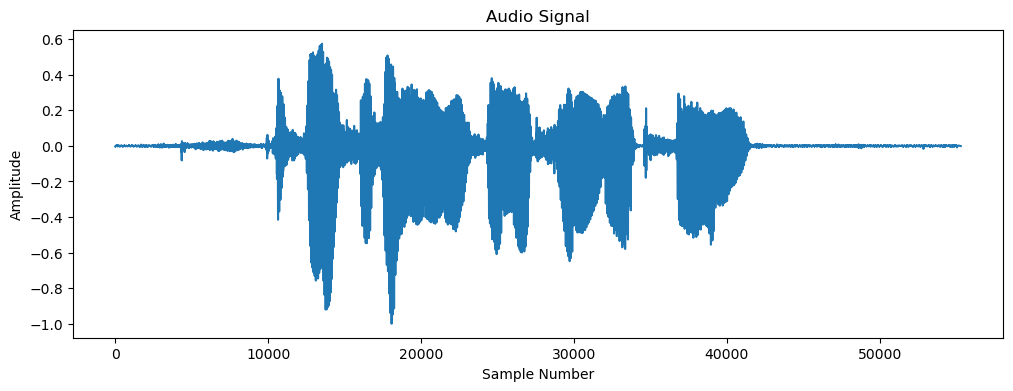

In [4]:
# Plot the samples
plt.figure(figsize=(12, 4))
plt.plot(custom_ge.y)

plt.title("Audio Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

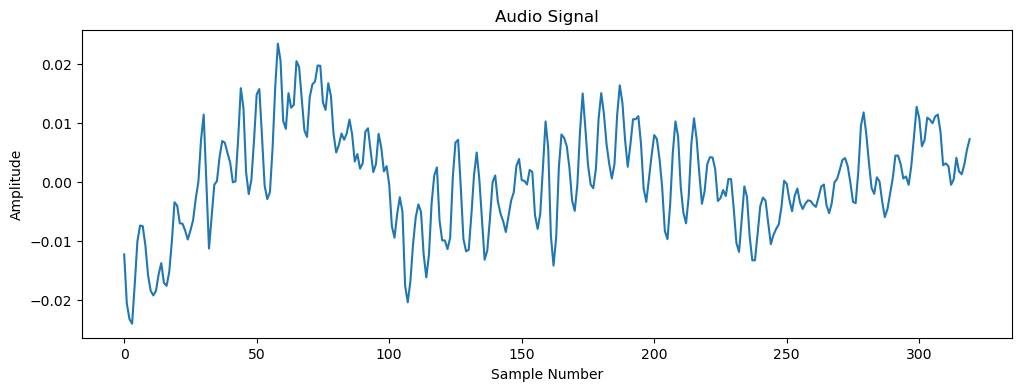

In [5]:
# Plot a short timeframe of the audio signal 
plt.figure(figsize=(12, 4))
length = 0.02 # lenghth of the timeframe in seconds
offset = 0.5 # offset in seconds
time_start = int(custom_ge.sr * offset)
time_end = time_start + int(custom_ge.sr * length)
plt.plot(custom_ge.y[time_start:time_end])

plt.title("Audio Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")

# Into the Frequency domain!
Visualize the audio file in the frequency domain using the spectrogram function of the Custom_GeMAPS class.

Text(0, 0.5, 'Magnitude (dB)')

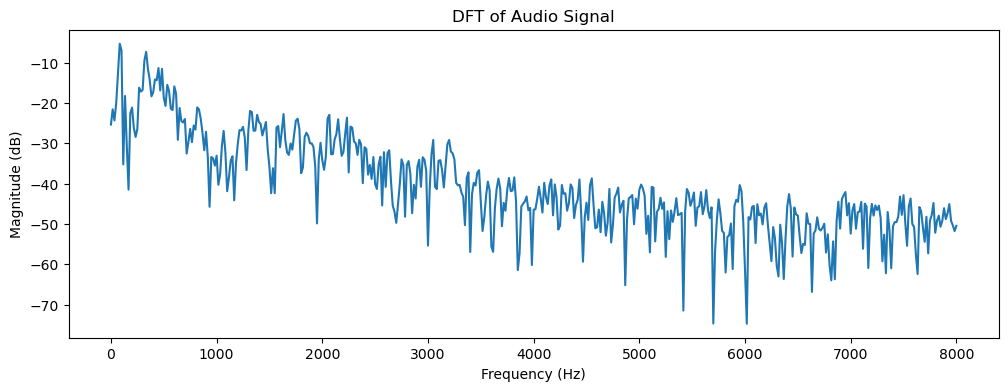

In [8]:
# The DFT
offset = 0.2 # offset in seconds

dft = custom_ge.dft(ts=offset, log_values=True)


plt.figure(figsize=(12, 4))
plt.plot(dft[:, 0], dft[:, 1])
plt.title("DFT of Audio Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

Text(0, 0.5, 'Frequency (Hz)')

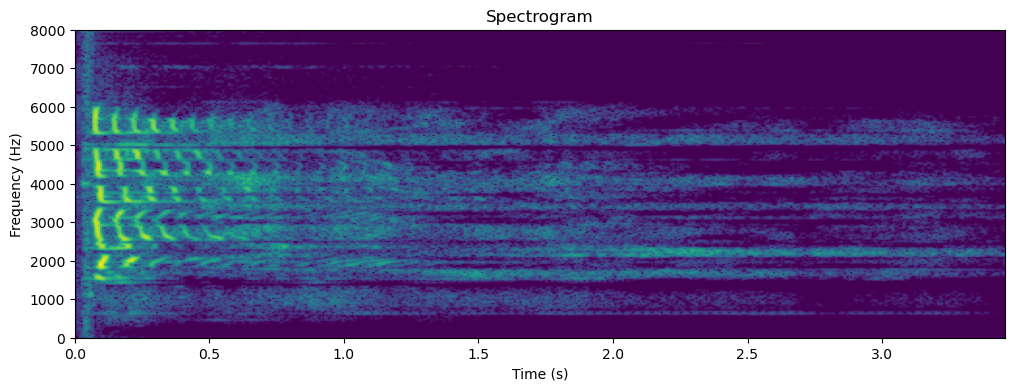

In [7]:
# The Spectrogram

spectrogram = custom_ge.spectrogram(log_values=True)

plt.figure(figsize=(12, 4))
plt.imshow(
    spectrogram.T,
    aspect="auto",
    origin="lower",
    extent=[0, custom_ge.y.shape[0] / custom_ge.sr, 0, custom_ge.sr / 2],
)
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")